In [1]:
import os
import sys
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
import matplotlib.pyplot as plt
from IPython.display import Video


sys.path.append(os.getcwd())

In [2]:
def format_cols(df):
    for col in df.columns:
        if df[col].dtype != 'O':
            continue
        df[col] = df[col].apply(lambda x: eval(x) if isinstance(x, str) else x)
        df[[f'{col}_x', f'{col}_y']] = pd.DataFrame(df[col].tolist(), index=df.index)
        del df[col]
    return df

def get_and_process_dataframe(file_path):
    df = pd.read_csv(file_path)

    # PREPROCESSING
    df['date'] = pd.to_datetime(df['timestamp'], unit='s')
    df = format_cols(df) # Originally each pair of coord comes in string. This function splits them into x and y columns
    df.loc[:, (df.columns.str.contains('x')) | (df.columns.str.contains('y'))] = df.loc[:, (df.columns.str.contains('x')) | (df.columns.str.contains('y'))].replace(0.0, np.nan)
    del df['timestamp'] # We don't need this anymore
    del df['left_ear_x'] # non tracked, all Nans
    del df['left_ear_y'] # non tracked, all Nans
    del df['frame'] # We don't need this anymore

    # IMPUTATION OF MISSING VALUES
    imp = IterativeImputer(missing_values=np.nan, max_iter=20, random_state=0)
    df.loc[:,df.columns.str.contains('x') | df.columns.str.contains('y')] = imp.fit_transform(df.loc[:,df.columns.str.contains('x') | df.columns.str.contains('y')])
    return df

def filter_for_person(df, person_id):
    df_p = df[df.person == person_id].reset_index(drop=True)
    # PREPROCESSING FOR PERSON MOVEMENTS
    x_joints = df_p.loc[:,df_p.columns.str.contains('x')].describe()
    min_x = x_joints.loc["min",:].min()
    max_x = x_joints.loc["max",:].max()
    y_joints = df_p.loc[:,df_p.columns.str.contains('y')].describe()
    min_y = y_joints.loc["min",:].min()
    max_y = y_joints.loc["max",:].max()
    df_p.loc[:,df_p.columns.str.contains('x')] = df_p.loc[:,df_p.columns.str.contains('x')] / max_x
    df_p.loc[:,df_p.columns.str.contains('y')] = df_p.loc[:,df_p.columns.str.contains('y')] / max_y
    df_p.loc[:,df_p.columns.str.contains('y')] = 1 - df_p.loc[:,df_p.columns.str.contains('y')]
    return df_p

def format_for_viz(df_p):
    df_p_melted = df_p.melt(id_vars=[ 'person', 'date'], 
                            value_vars=[col for col in df_p.columns if '_x' in col or '_y' in col], 
                            var_name='body_part', value_name='coordinate')

    df_p_melted['axis'] = df_p_melted['body_part'].apply(lambda x: 'x' if '_x' in x else 'y')
    df_p_melted['body_part'] = df_p_melted['body_part'].apply(lambda x: x.replace('_x', '').replace('_y', ''))

    df_p_wide = df_p_melted.pivot_table(index=['person', 'date', 'body_part'], 
                                        columns='axis', values='coordinate').reset_index()

    df_p_wide['body_part'] = df_p_wide['body_part'].replace({
        'left_elbow': 'elbow',
        'right_elbow': 'elbow',
        'left_knee': 'knee',
        'right_knee': 'knee',
        'left_shoulder': 'shoulder',
        'right_shoulder': 'shoulder',
        'left_hip': 'hip',
        'right_hip': 'hip',
        'left_wrist': 'wrist',
        'right_wrist': 'wrist',
        'left_ankle': 'ankle',
        'right_ankle': 'ankle',
        'left_eye': 'eye',
        'right_eye': 'eye',
        'left_ear': 'ear',
        'right_ear': 'ear',
        'nose': 'nose',
        'left_eye': 'eye',
        'right_eye': 'eye',

    })
    return df_p_wide

# Baseline (0Kg)

In [3]:
Video(filename="runs/pose/track2/0kg_video.mp4")

In [4]:
file_path = "videos/output/0kg_video.csv"


df = get_and_process_dataframe(file_path)
df.head(3)

person                          date      nose_x      nose_y  left_eye_x  \
0       0 2024-11-16 02:00:26.789320469  338.098541  394.321014  299.263739   
1       0 2024-11-16 02:00:27.695616722  337.908722  404.471619  296.561237   
2       0 2024-11-16 02:00:28.284234762  336.734924  408.669342  296.508459   

   left_eye_y  right_eye_x  right_eye_y  right_ear_x  right_ear_y  ...  \
0  357.186119   331.826202   385.282013   302.359161   391.590149  ...   
1  366.015523   331.195221   396.152466   300.480927   404.935608  ...   
2  370.658796   329.254822   400.493591   298.806488   409.224091  ...   

   right_hip_x  right_hip_y  left_knee_x  left_knee_y  right_knee_x  \
0   157.525543   570.889893   260.874451   585.919739    285.845642   
1   157.863235   578.310242   258.980042   589.516052    285.818176   
2   159.389633   579.375366   259.643341   591.776733    287.707520   

   right_knee_y  left_ankle_x  left_ankle_y  right_ankle_x  right_ankle_y  
0    600.457336    194.329926    692.375610     196.934082     707.914307  
1    600.775085    191.573502    696.429382     194.649139     708.592590  
2    603.098328    190.384064    697.163147     196.698685     710.111816  

[3 rows x 34 columns]

In [5]:
person_id = 0

df_p = filter_for_person(df, person_id)
df_p.head(3)

person                          date    nose_x    nose_y  left_eye_x  \
0       0 2024-11-16 02:00:26.789320469  0.883945  0.477709    0.998964   
1       0 2024-11-16 02:00:27.695616722  0.883449  0.464264    0.998973   
2       0 2024-11-16 02:00:28.284234762  0.880380  0.458704    0.998973   

   left_eye_y  right_eye_x  right_eye_y  right_ear_x  right_ear_y  ...  \
0    0.526896     0.998851     0.489682     0.790506     0.481326  ...   
1    0.515201     0.998853     0.475283     0.785596     0.463650  ...   
2    0.509051     0.998860     0.469534     0.781218     0.457970  ...   

   right_hip_x  right_hip_y  left_knee_x  left_knee_y  right_knee_x  \
0     0.411844     0.243838     0.682046     0.223931      0.747332   
1     0.412727     0.234010     0.677093     0.219167      0.747260   
2     0.416718     0.232599     0.678827     0.216173      0.752200   

   right_knee_y  left_ankle_x  left_ankle_y  right_ankle_x  right_ankle_y  
0      0.204675      0.508068      0.082926       0.514876       0.062345  
1      0.204254      0.500861      0.077557       0.508903       0.061447  
2      0.201177      0.497752      0.076585       0.514261       0.059434  

[3 rows x 34 columns]

In [6]:
df_p_wide = format_for_viz(df_p)
fig = px.scatter(df_p_wide, x="x", y="y",color="body_part", animation_frame="date", range_x=[0, 1], range_y=[0, 1], width=800, height=800)
fig.update_layout(xaxis_title='X Coordinate', yaxis_title='Y Coordinate', title='Joints 2D Translation By Datetime')
fig.show()

fig = px.scatter(df_p_wide, x="x", y="y",color="body_part", hover_data="date", range_x=[0, 1], range_y=[0, 1], width=800, height=800)
fig.update_layout(xaxis_title='X Coordinate', yaxis_title='Y Coordinate', title='Joints 2D Translation (All samples)')

fig.show()

In [7]:
# CORRELATION BETWEEN JOINTS
X = df_p.loc[:,df_p.columns.str.contains('x') | df_p.columns.str.contains('y')]
X.corr().style.background_gradient(cmap='coolwarm')

cumsum_exp_var:  [0.90192356 0.95656221 0.9801782 ] ...
eigens:  [0.21765245 0.01318541 0.00569902] ...


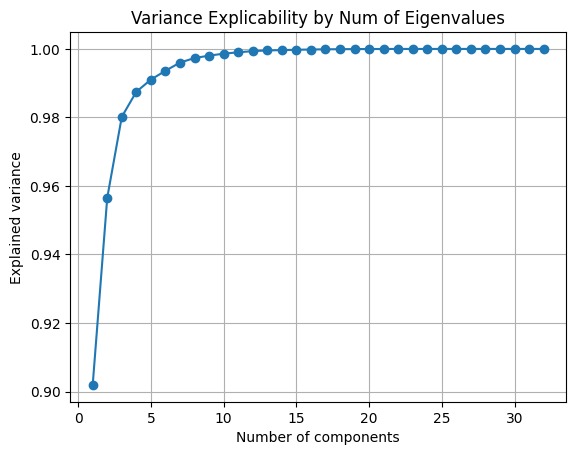

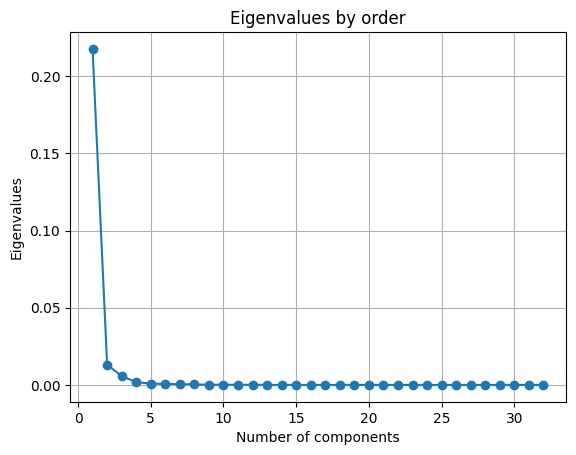

In [8]:
# CHECK EXPLAINABILITY OF ALL EIGENVALUES
pca = PCA(n_components=None)
X_pca = pca.fit(X)
exp_var = X_pca.explained_variance_ratio_
eigens = pca.explained_variance_
n_components = np.arange(1, len(exp_var)+1)
cumsum_exp_var = np.cumsum(exp_var)
print("cumsum_exp_var: ", cumsum_exp_var[:3],"...")
print("eigens: ", eigens[:3],"...")
plt.plot(n_components, cumsum_exp_var, 'o-')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.title('Variance Explicability by Num of Eigenvalues')
plt.grid()
plt.show()
plt.plot(n_components, eigens, 'o-')
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')
plt.title('Eigenvalues by order')
plt.grid()
plt.show()


cumsum_exp_var:  [0.90192356 0.95656221 0.9801782 ] ...
eigens:  [0.21765245 0.01318541 0.00569902] ...


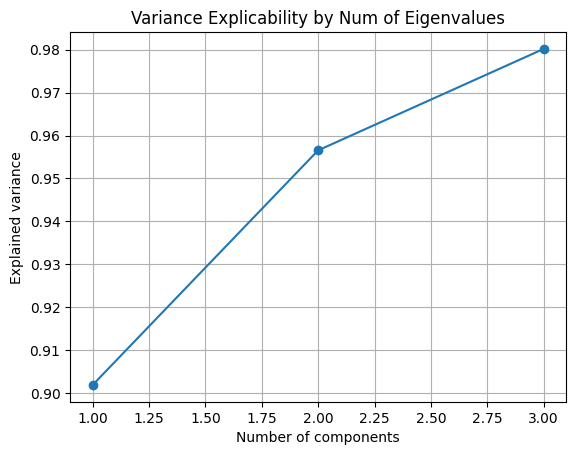

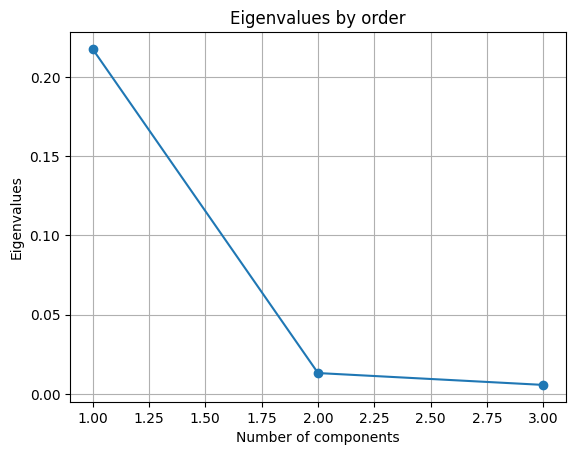

In [9]:
# I Take only 3 values. APPLY PCA
pca = PCA(n_components=3)
X_pca = pca.fit(X)
exp_var = X_pca.explained_variance_ratio_
eigens = pca.explained_variance_
n_components = np.arange(1, len(exp_var)+1)
cumsum_exp_var = np.cumsum(exp_var)
print("cumsum_exp_var: ", cumsum_exp_var[:3],"...")
print("eigens: ", eigens[:3],"...")
plt.plot(n_components, cumsum_exp_var, 'o-')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.title('Variance Explicability by Num of Eigenvalues')
plt.grid()
plt.show()
plt.plot(n_components, eigens, 'o-')
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')
plt.title('Eigenvalues by order')
plt.grid()
plt.show()

In [10]:
pca_j_df = pd.DataFrame(pca.transform(X), columns=[f'joint_pca_{i}' for i in range(1, 4)])
df_p = pd.concat([df_p[["person",	"date"]], pca_j_df], axis=1)
df_p

person                          date  joint_pca_1  joint_pca_2  \
0         0 2024-11-16 02:00:26.789320469    -0.235680     0.113867   
1         0 2024-11-16 02:00:27.695616722    -0.276273     0.086665   
2         0 2024-11-16 02:00:28.284234762    -0.287964     0.084516   
3         0 2024-11-16 02:00:28.838766575    -0.292938     0.073050   
4         0 2024-11-16 02:00:29.459204197    -0.286872     0.072585   
..      ...                           ...          ...          ...   
222       0 2024-11-16 02:02:34.829397917     0.506149    -0.308615   
223       0 2024-11-16 02:02:35.389252186     0.562366    -0.351685   
224       0 2024-11-16 02:02:36.009114981     0.625710    -0.395184   
225       0 2024-11-16 02:02:36.574300766     0.674638    -0.441243   
226       0 2024-11-16 02:02:37.128811598     0.731616    -0.484832   

     joint_pca_3  
0       0.011353  
1       0.034584  
2       0.041749  
3       0.048330  
4       0.056544  
..           ...  
222    -0.125217  
223    -0.102228  
224    -0.098336  
225    -0.085381  
226    -0.078158  

[227 rows x 5 columns]

In [11]:
range_jp1 = df_p.joint_pca_1.min(), df_p.joint_pca_1.max()
range_jp2 = df_p.joint_pca_2.min(), df_p.joint_pca_2.max()

fig = px.scatter(df_p, x="joint_pca_2", y="joint_pca_1", color="joint_pca_3", animation_frame="date", range_x=range_jp2, range_y=range_jp1, width=800, height=800)
fig.update_traces(marker=dict(size=10))  # Increase the size of the points
fig.show()

# Create the animated scatter plot with lines and markers
fig = px.scatter(df_p, 
                 x="joint_pca_2", 
                 y="joint_pca_1", 
                 color="joint_pca_3", 
                 hover_data="date" ,
                 range_x=range_jp2, 
                 range_y=range_jp1, 
                 width=800, 
                 height=800)

# Add traces by connecting points over time
fig.update_traces(marker=dict(size=10), mode='lines+markers') 

fig.show()



In [12]:
Video(filename="videos/output/0kg_video.mp4")

# Looks Great, but... fails due to occlutions when tracking (50Kg)

In [18]:
Video(filename="runs/pose/track3/50kg_video.mp4")

In [44]:
Video(filename="videos/output/50kg_video.mp4")

# We'll try a different Perspective (70Kg)

In [13]:
Video(filename="runs/pose/track4/70kg_video.mp4")

In [16]:
file_path = "videos/output/70kg_video.csv"
person_id = 0

df = get_and_process_dataframe(file_path)
df_p = filter_for_person(df, person_id)
df_p_wide = format_for_viz(df_p)

# VIZ
fig = px.scatter(df_p_wide, x="x", y="y",color="body_part", animation_frame="date", range_x=[0, 1], range_y=[0, 1], width=800, height=800)
fig.update_layout(xaxis_title='X Coordinate', yaxis_title='Y Coordinate', title='Joints 2D Translation By Datetime')
fig.show()

fig = px.scatter(df_p_wide, x="x", y="y",color="body_part", hover_data="date", range_x=[0, 1], range_y=[0, 1], width=800, height=800)
fig.update_layout(xaxis_title='X Coordinate', yaxis_title='Y Coordinate', title='Joints 2D Translation (All samples)')

fig.show()

c:\Users\jorge\anaconda3\envs\yolo\Lib\site-packages\sklearn\impute\_iterative.py:825: ConvergenceWarning:

[IterativeImputer] Early stopping criterion not reached.



cumsum_exp_var:  [0.85091695 0.96426473 0.98565499] ...
eigens:  [0.11594278 0.01544435 0.00291456] ...


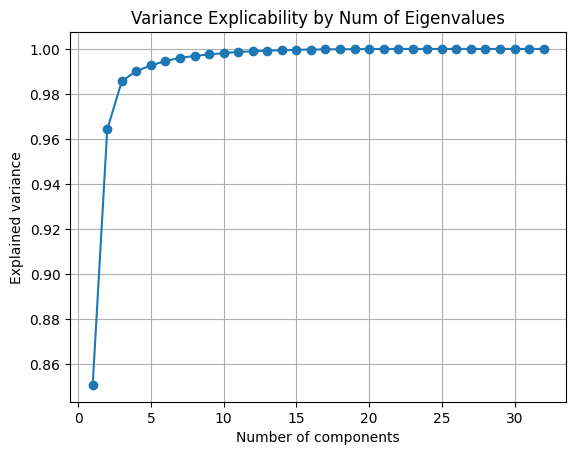

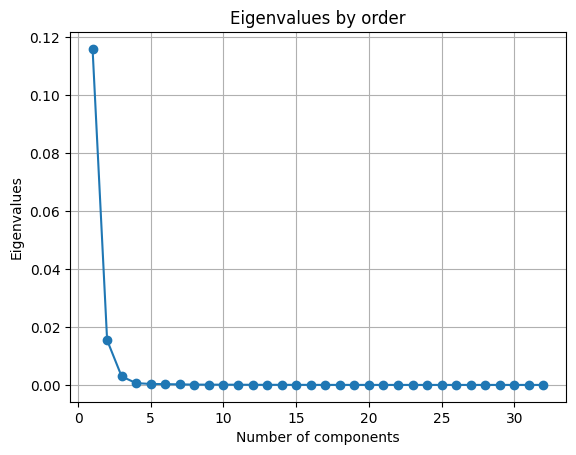

In [19]:
# CHECK EXPLAINABILITY OF ALL EIGENVALUES (AGAIN - VARIANCE CHANGES IN 2D PERSPECTIVES)
pca = PCA(n_components=None)
X = df_p.loc[:,df_p.columns.str.contains('x') | df_p.columns.str.contains('y')]
X_pca = pca.fit(X)
exp_var = X_pca.explained_variance_ratio_
eigens = pca.explained_variance_
n_components = np.arange(1, len(exp_var)+1)
cumsum_exp_var = np.cumsum(exp_var)
print("cumsum_exp_var: ", cumsum_exp_var[:3],"...")
print("eigens: ", eigens[:3],"...")
plt.plot(n_components, cumsum_exp_var, 'o-')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.title('Variance Explicability by Num of Eigenvalues')
plt.grid()
plt.show()
plt.plot(n_components, eigens, 'o-')
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')
plt.title('Eigenvalues by order')
plt.grid()
plt.show()

cumsum_exp_var:  [0.85091695 0.96426473 0.98565499] ...
eigens:  [0.11594278 0.01544435 0.00291456] ...


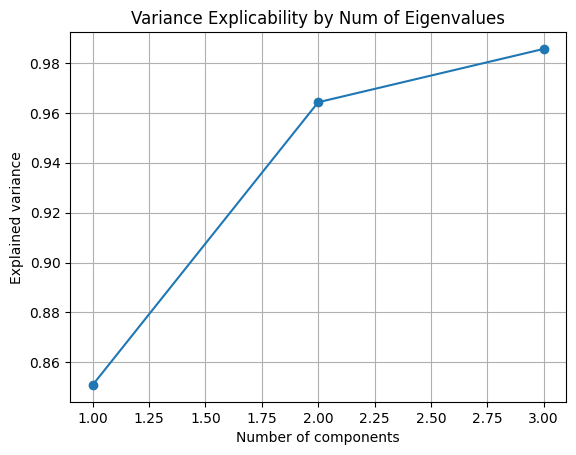

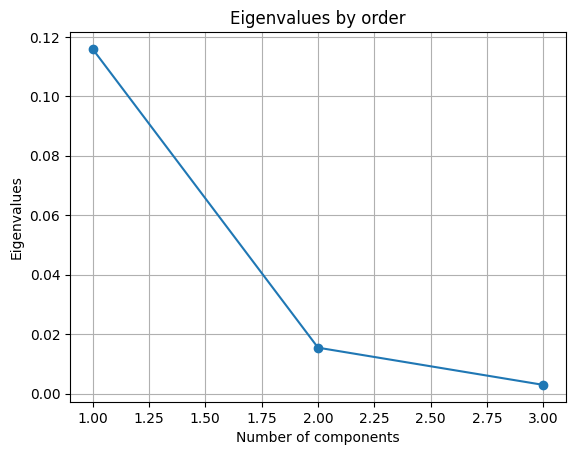

In [20]:
# 3 eigenvalues are still reasonable. APPLY PCA
pca = PCA(n_components=3)
X_pca = pca.fit(X)
exp_var = X_pca.explained_variance_ratio_
eigens = pca.explained_variance_
n_components = np.arange(1, len(exp_var)+1)
cumsum_exp_var = np.cumsum(exp_var)
print("cumsum_exp_var: ", cumsum_exp_var[:3],"...")
print("eigens: ", eigens[:3],"...")
plt.plot(n_components, cumsum_exp_var, 'o-')
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.title('Variance Explicability by Num of Eigenvalues')
plt.grid()
plt.show()
plt.plot(n_components, eigens, 'o-')
plt.xlabel('Number of components')
plt.ylabel('Eigenvalues')
plt.title('Eigenvalues by order')
plt.grid()
plt.show()

In [22]:
pca_j_df = pd.DataFrame(pca.transform(X), columns=[f'joint_pca_{i}' for i in range(1, 4)])
df_p = pd.concat([df_p[["person",	"date"]], pca_j_df], axis=1)
range_jp1 = df_p.joint_pca_1.min(), df_p.joint_pca_1.max()
range_jp2 = df_p.joint_pca_2.min(), df_p.joint_pca_2.max()

fig = px.scatter(df_p, x="joint_pca_2", y="joint_pca_1", color="joint_pca_3", animation_frame="date", range_x=range_jp2, range_y=range_jp1, width=800, height=800)
fig.update_traces(marker=dict(size=10))  # Increase the size of the points
fig.show()

# Create the animated scatter plot with lines and markers
fig = px.scatter(df_p, 
                 x="joint_pca_2", 
                 y="joint_pca_1", 
                 color="joint_pca_3", 
                 hover_data="date" ,
                 range_x=range_jp2, 
                 range_y=range_jp1, 
                 width=800, 
                 height=800)

# Add traces by connecting points over time
fig.update_traces(marker=dict(size=10), mode='lines+markers') 

fig.show()



# Now keep adding more weight and see how the pattern changes

![alt text](../presentation/ifhedieshedies.gif)